# NYC Donation Analysis: Coalition + Geography (Zohran vs Cuomo et al)

In [1]:
import pandas as pd

In [2]:
# Load candidate CSVs
zohran_df = pd.read_csv("Zohran.csv")
cuomo_df = pd.read_csv("Cuomo.csv")
garcia_df = pd.read_csv("Garcia.csv")
wiley_df = pd.read_csv("Maya.csv")
yang_df = pd.read_csv("Yang.csv")
adams_df = pd.read_csv("Mayor_Adams_2021.csv")


/var/folders/33/zzhwcx3s0n97jltxvr3t2hjr0000gn/T/ipykernel_22139/959926580.py:5: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  wiley_df = pd.read_csv("Maya.csv")
/var/folders/33/zzhwcx3s0n97jltxvr3t2hjr0000gn/T/ipykernel_22139/959926580.py:6: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  yang_df = pd.read_csv("Yang.csv")


In [3]:
# Clean ZIP codes
def clean_zip(df):
    df["ZIP"] = df["ZIP"].astype(str).str.zfill(5)
    return df

dfs = [zohran_df, cuomo_df, garcia_df, wiley_df, yang_df, adams_df]
dfs = [clean_zip(df) for df in dfs]
zohran_df, cuomo_df, garcia_df, wiley_df, yang_df, adams_df = dfs


In [4]:
from functools import reduce

def count_by_zip(df, name):
    return df["ZIP"].value_counts().rename(name).to_frame()

zip_counts = reduce(
    lambda left, right: left.join(right, how="outer"),
    [count_by_zip(zohran_df, "Zohran"),
     count_by_zip(cuomo_df, "Cuomo"),
     count_by_zip(wiley_df, "Wiley"),
     count_by_zip(garcia_df, "Garcia"),
     count_by_zip(yang_df, "Yang"),
     count_by_zip(adams_df, "Adams")]
).fillna(0).astype(int)

zip_counts["Progressive_Total"] = zip_counts[["Zohran", "Wiley", "Garcia"]].sum(axis=1)
zip_counts["Centrist_Total"] = zip_counts[["Cuomo", "Adams", "Yang"]].sum(axis=1)
zip_counts["Margin"] = zip_counts["Progressive_Total"] - zip_counts["Centrist_Total"]
zip_counts = zip_counts.sort_values(by="Margin")
zip_counts.head(10)


,Zohran,Cuomo,Wiley,Garcia,Yang,Adams,Progressive_Total,Centrist_Total,Margin
ZIP,,,,,,,,,
11355,34,6,14,7,151,225,55,382,-327
11354,29,4,15,22,162,226,66,392,-326
11223,20,7,32,19,40,253,71,300,-229
11236,10,3,67,6,10,264,83,277,-194
11234,26,12,70,33,28,275,129,315,-186
11214,26,5,16,13,111,100,55,216,-161
11364,14,3,12,22,80,124,48,207,-159
11375.0,0,0,12,0,156,0,12,156,-144
11235,29,2,47,13,38,190,89,230,-141


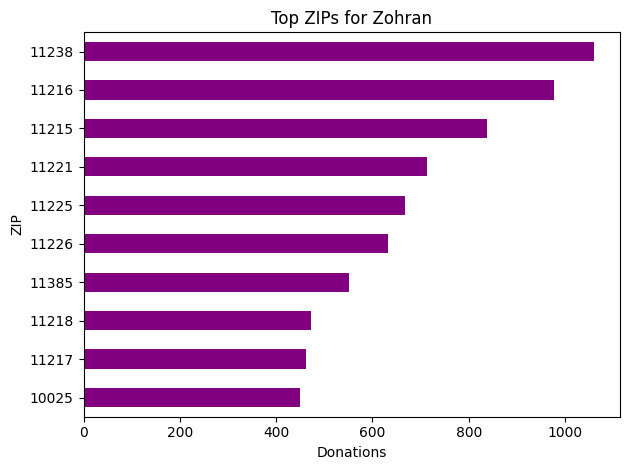

In [5]:
import matplotlib.pyplot as plt

# Top 10 ZIPs for Zohran
zohran_top = zip_counts["Zohran"].sort_values(ascending=False).head(10)

zohran_top.plot(kind="barh", color="purple", title="Top ZIPs for Zohran")
plt.xlabel("Donations")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Optional: Add a WKT-based map using GeoPandas + shapefile or WKT CSV

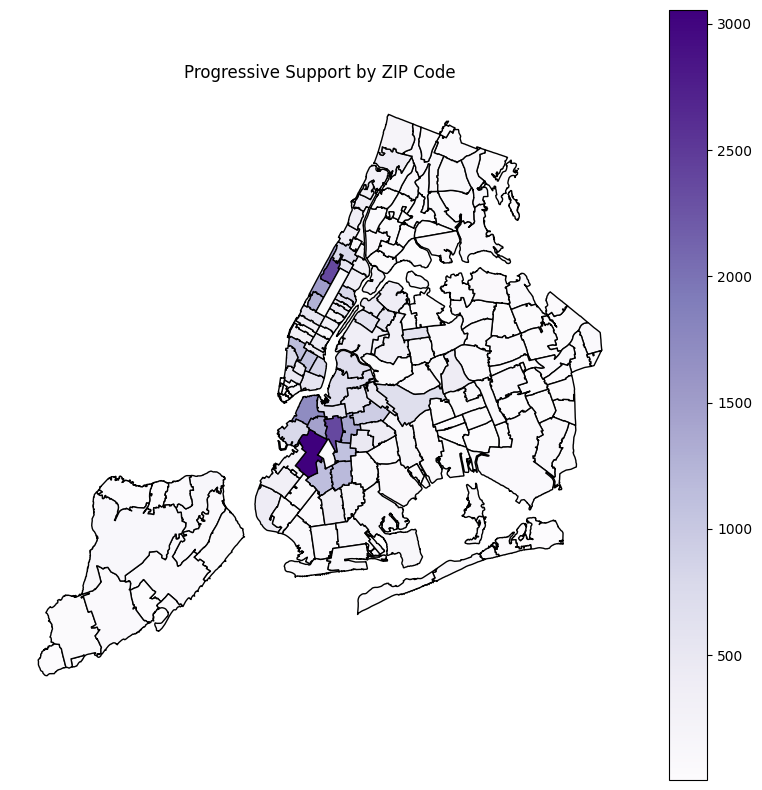

In [7]:
import geopandas as gpd
from shapely import wkt

# Load the ZIP geometry CSV
zip_shapes = pd.read_csv("Modified_Zip_Code_Tabulation_Areas__MODZCTA__20250418.csv")

# Convert the_geom (WKT) to geometry
zip_shapes["geometry"] = zip_shapes["the_geom"].apply(wkt.loads)
zip_shapes = gpd.GeoDataFrame(zip_shapes, geometry="geometry", crs="EPSG:4326")

# Ensure ZIPs match the format used in donation data
zip_shapes["ZIP"] = zip_shapes["MODZCTA"].astype(str).str.zfill(5)
zip_counts_reset = zip_counts.reset_index()  # from earlier
zip_shapes = zip_shapes.merge(zip_counts_reset, on="ZIP", how="left")

# Plot total progressive support by ZIP
zip_shapes.plot(column="Progressive_Total", cmap="Purples", legend=True, edgecolor="black", figsize=(10, 10))
plt.title("Progressive Support by ZIP Code")
plt.axis("off")
plt.show()

In [9]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 11.2 MB/s eta 0:00:0000:0100:01
ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

Note: you may need to restart the kernel to use updated packages.


In [8]:
import plotly.express as px

fig = px.choropleth_mapbox(
    zip_shapes,
    geojson=zip_shapes.geometry.__geo_interface__,
    locations=zip_shapes.index,
    color="Zohran",
    hover_name="ZIP",
    mapbox_style="carto-positron",
    center={"lat": 40.7, "lon": -73.95},
    zoom=9
)
fig.show()

ModuleNotFoundError: No module named 'plotly'